In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

In [2]:
# Load preprocessed data for analysis
preprocessed_data=pd.read_csv('../Data/PreProcessedData.csv')

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(preprocessed_data.shape)))
display(HTML('<span style="font-weight:bold;">Data Overview:</span>'))
print(f"Total Variables: {len(preprocessed_data.columns)}")
print(f"Categorical Variables: {len([col for col in preprocessed_data.columns if col not in ['age', 'wgt']])} (Cardinal/Ordinal)")
print(f"Continuous Variables: {len(['age'])} (Age)")
print(f"Survey Weights: wgt")

display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(preprocessed_data.head().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))
display(preprocessed_data.tail().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))

display(HTML('<span style="font-weight:bold;">Data Info:</span>'))

info_table = pd.DataFrame({
    'Variables': preprocessed_data.columns,
    'Dtype': preprocessed_data.dtypes,
    'Unique Values': preprocessed_data.nunique(),
    'Null Values (%)': (preprocessed_data.isnull().sum().to_numpy() * 100 / len(preprocessed_data)).round(2)
})
info_table.index = pd.RangeIndex(start=1, stop=len(info_table) + 1)
info_table

Total Variables: 18
Categorical Variables: 16 (Cardinal/Ordinal)
Continuous Variables: 1 (Age)
Survey Weights: wgt


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,wages,transfers,pension,agri_sale,utilities,remittances,mobile,internet
0,0.330000,1,18,3,3,2,1,1,0,0,4,4,4,4,2,5,1,1
1,1.330000,2,41,1,1,2,2,1,0,0,4,4,4,4,1,5,2,2
2,1.460000,2,23,1,2,1,2,1,0,1,2,4,4,4,2,5,1,2
3,0.390000,1,17,2,2,2,1,1,0,0,4,4,4,4,4,5,1,2
4,2.420000,2,27,1,1,1,2,1,1,0,4,3,4,4,3,5,2,2


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,wages,transfers,pension,agri_sale,utilities,remittances,mobile,internet
2995,2.110000,2,65,1,1,1,2,1,0,1,1,3,4,4,4,5,1,2
2996,0.700000,2,32,1,5,1,2,1,0,0,4,4,4,4,2,1,1,1
2997,1.610000,2,18,2,2,1,2,0,0,0,4,4,4,4,4,5,1,2
2998,0.840000,2,36,2,4,1,2,1,0,1,4,4,4,4,2,5,1,1
2999,0.920000,2,48,3,5,1,2,1,1,0,4,3,4,4,4,4,1,1


,Variables,Dtype,Unique Values,Null Values (%)
1,wgt,float64,212,0.0
2,gender,int64,2,0.0
3,age,int64,70,0.0
4,ed_lvl,int64,5,0.0
5,income_q,int64,5,0.0
6,employed,int64,2,0.0
7,rural,int64,2,0.0
8,account,int64,2,0.0
9,savings,int64,2,0.0
10,loans,int64,2,0.0


**Insights:**
1. Check for correlation between features - PCA, trimming may be required.
2. Categorical variables may require merging or trimming depending on class imbalance.
3. Cardinal categorical variables may require one hot, re-encoding(0,1) or target encoding depending on cardinality.
4. Age variable might require deailing with outliers/ transformation. 
5. Sclaing should be done for age and other ordinal variables.

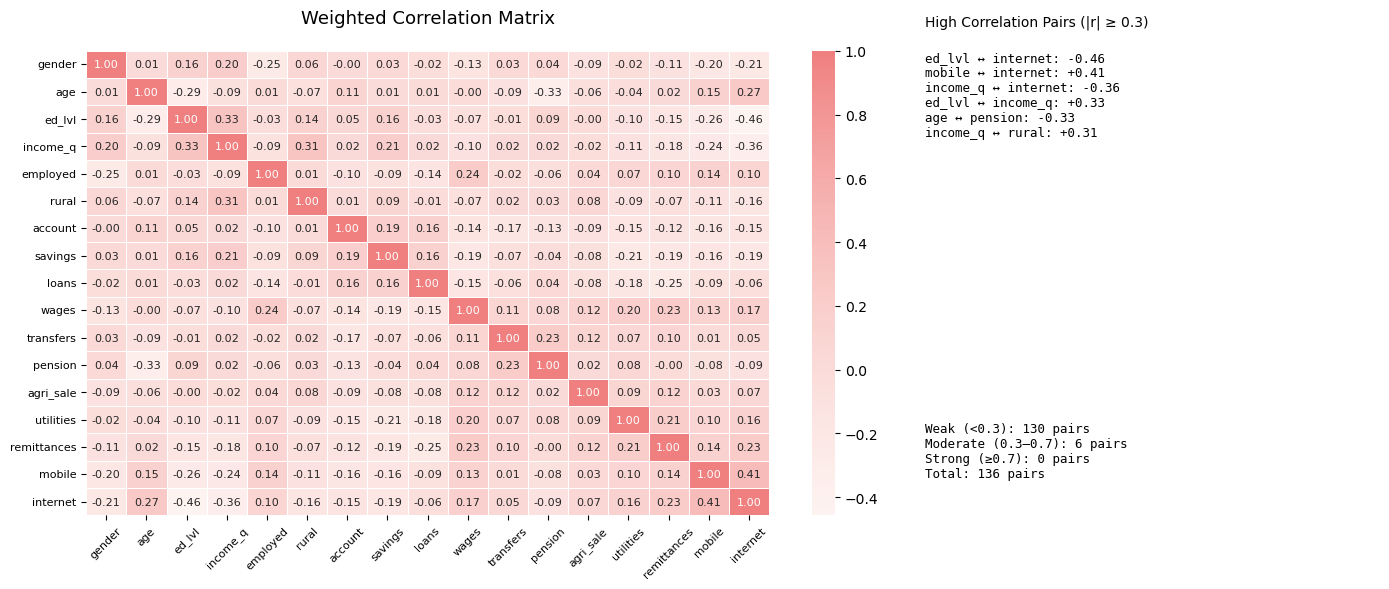

In [3]:
# Correlation Matrix
df = preprocessed_data.copy()
weights = df['wgt'].to_numpy()
df = df.drop(columns=['wgt'])

mean = np.average(df, axis=0, weights=weights)
cov = np.dot((weights * (df - mean).T), (df - mean)) / weights.sum()
std = np.sqrt(np.diag(cov))
corr_df = pd.DataFrame(cov / np.outer(std, std), index=df.columns, columns=df.columns)

corr_pairs = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool)).stack().reset_index()
corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlation']
corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()
high_corr_pairs = corr_pairs.query('Abs_Correlation >= 0.3').sort_values('Abs_Correlation', ascending=False)

corr_vals = np.abs(corr_df.values[np.triu_indices_from(corr_df.values, 1)])
weak, moderate, strong = (sum(corr_vals < 0.3), sum((corr_vals >= 0.3) & (corr_vals < 0.7)), sum(corr_vals >= 0.7))
total_pairs = len(corr_vals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1.6]})
white_coral = mcolors.LinearSegmentedColormap.from_list("white_coral", ["#FFF2E800", "#F08080"])
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap=white_coral, center=0,
            linewidths=0.5, annot_kws={'fontsize': 8}, ax=ax1)
ax1.set_title("Weighted Correlation Matrix", fontsize=13, pad=20)
ax1.tick_params(axis='x', rotation=45, labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax2.axis('off')
ax2.set_title("High Correlation Pairs (|r| ≥ 0.3)\n", loc='left', fontsize=10)
if not high_corr_pairs.empty:
    table_text = "\n".join([
        f"{r.Variable_1} ↔ {r.Variable_2}: {r.Correlation:+.2f}"
        for _, r in high_corr_pairs.head(15).iterrows()  # top 15 for clarity
    ])
    ax2.text(0, 1, table_text, fontsize=9, family='monospace', va='top', ha='left')
else:
    ax2.text(0.5, 0.5, "No pairs ≥ 0.3", ha='center', va='center', fontsize=10)

summary_text = (
    f"Weak (<0.3): {weak} pairs\n"
    f"Moderate (0.3–0.7): {moderate} pairs\n"
    f"Strong (≥0.7): {strong} pairs\n"
    f"Total: {total_pairs} pairs"
)
ax2.text(0, 0.2, summary_text, fontsize=9, family='monospace', ha='left', va='top', transform=ax2.transAxes)

plt.tight_layout()
plt.show()

**Insights:**
1. There is very moderate correlation for only 6 pairs out of 136 pairs.
2. PCA or trimming is not required. Very light penalty can be used while training SVM or Decision Trees.

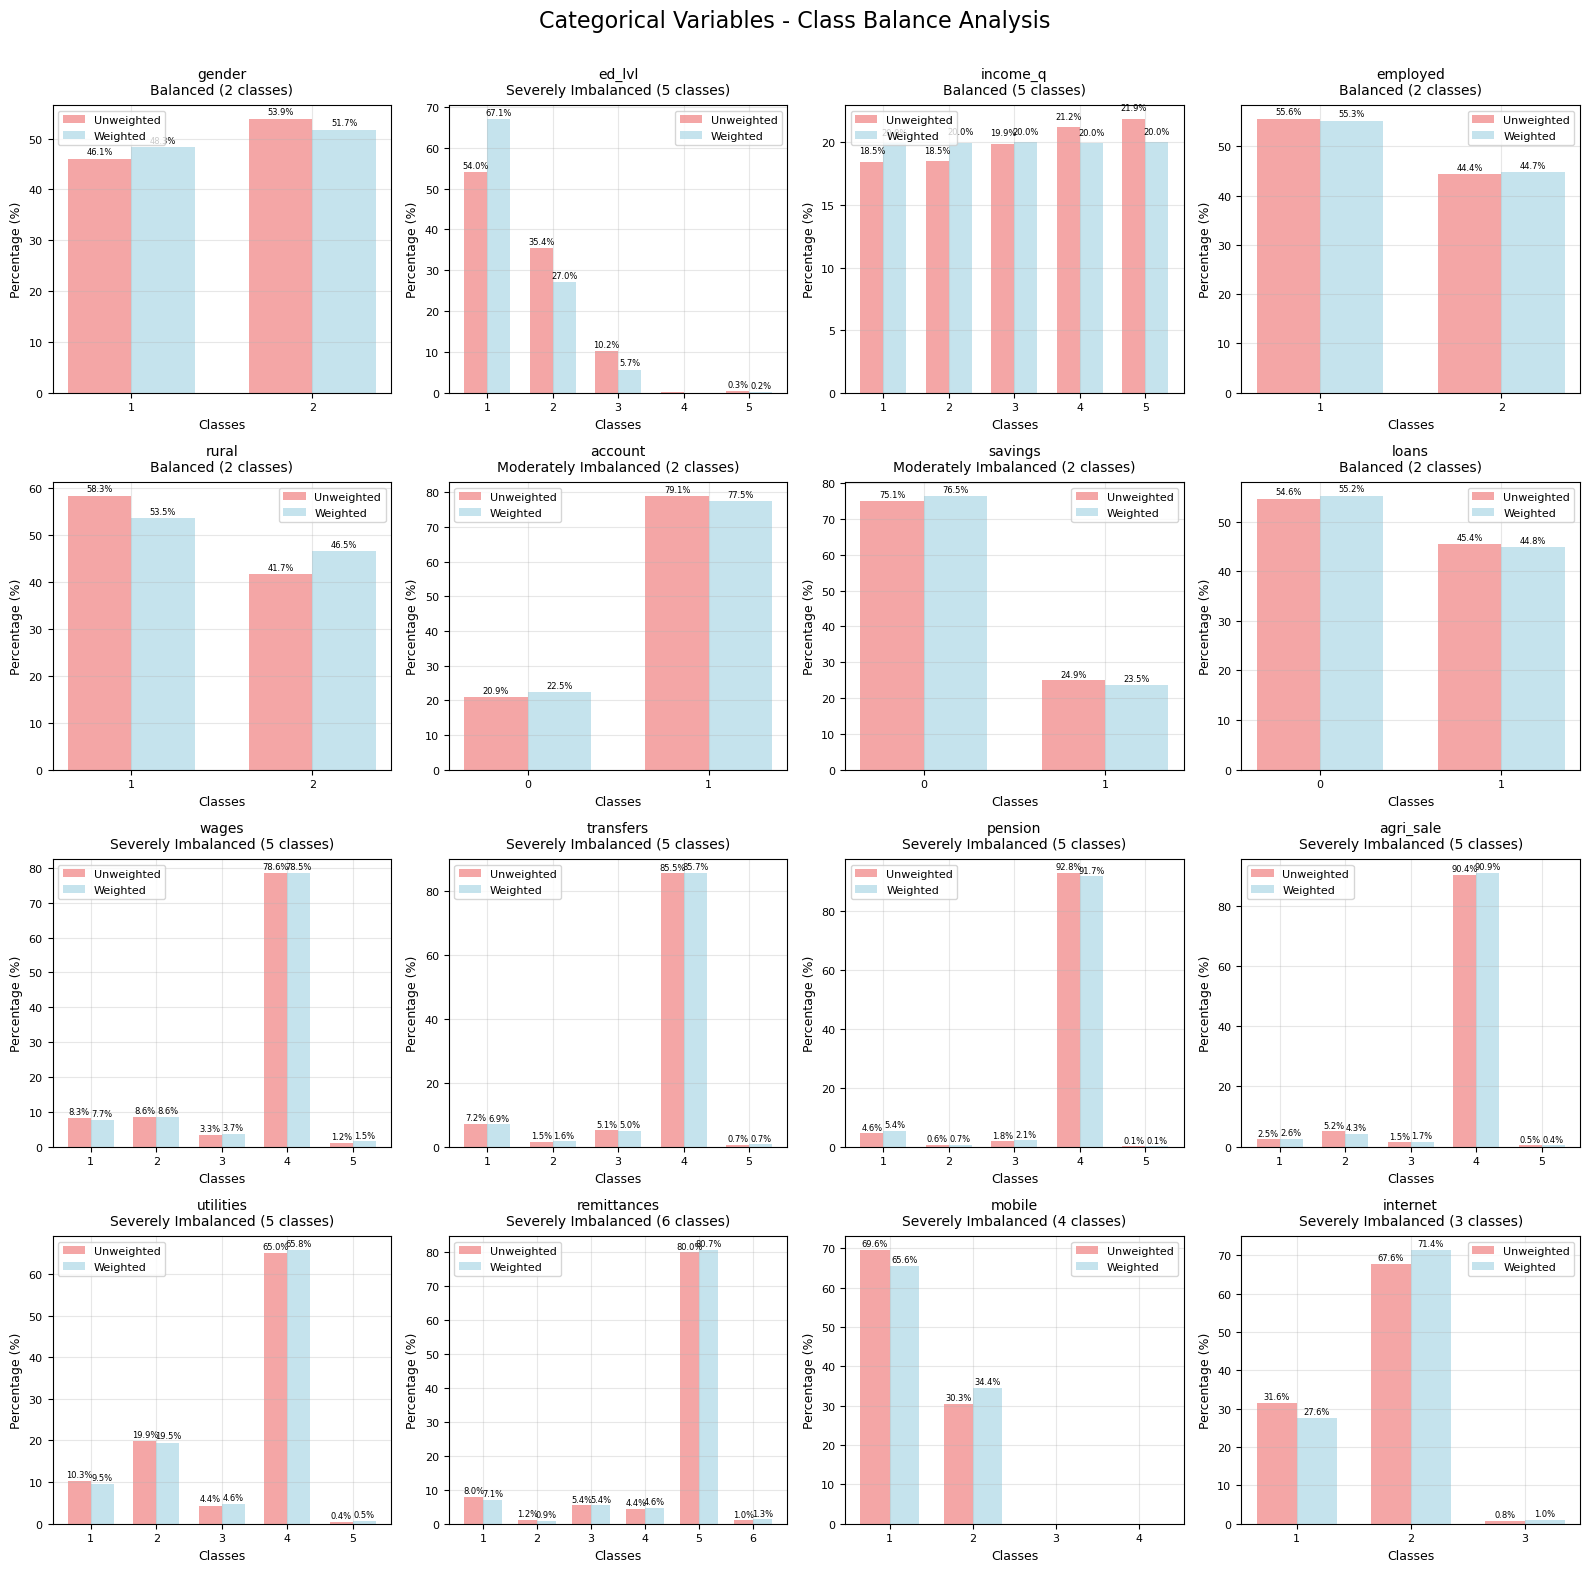

,classes,type,balance_status
gender,2,Binary,Balanced
ed_lvl,5,Multi-class (Ordinal),Severely Imbalanced
income_q,5,Multi-class (Ordinal),Balanced
employed,2,Binary,Balanced
rural,2,Binary,Balanced
account,2,Binary,Moderately Imbalanced
savings,2,Binary,Moderately Imbalanced
loans,2,Binary,Balanced
wages,5,Multi-class,Severely Imbalanced
transfers,5,Multi-class,Severely Imbalanced


In [4]:
# Categorical variables Analysis
df=preprocessed_data
categorical_vars = [col for col in df.columns if col not in ['age', 'wgt']]

# Visualization Format
n_categorical = len(categorical_vars)
n_cols = 4
n_rows = int(np.ceil(n_categorical / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

class_balance_summary = {}

for idx, col in enumerate(categorical_vars):
    if idx >= len(axes):
        break
        
    # Get value counts (unweighted and weighted)
    col_data = df[col].dropna()
    unweighted_counts = col_data.value_counts().sort_index()
    
    # Calculate weighted counts
    col_weights = df.loc[col_data.index, 'wgt']
    weighted_counts = col_data.groupby(col_data).apply(lambda x: col_weights[x.index].sum()).sort_index()
    weighted_props = weighted_counts / weighted_counts.sum() * 100
    unweighted_props = unweighted_counts / unweighted_counts.sum() * 100
    
    # Determine if binary or multi-class
    n_classes = len(unweighted_counts)
    is_binary = n_classes == 2
    
    # Calculate balance metrics
    if is_binary:
        # For binary: calculate minority class percentage
        balance_metric = min(weighted_props.values)
        balance_status = 'Balanced' if balance_metric >= 40 else 'Moderately Imbalanced' if balance_metric >= 20 else 'Severely Imbalanced'
    else:
        # For multi-class: calculate coefficient of variation
        balance_metric = weighted_props.std() / weighted_props.mean() * 100
        balance_status = 'Balanced' if balance_metric <= 50 else 'Moderately Imbalanced' if balance_metric <= 100 else 'Severely Imbalanced'
    
    class_balance_summary[col] = {
        'classes': n_classes,
        'type': 'Multi-class (Ordinal)' if col in ['ed_lvl', 'income_q'] else 'Binary' if is_binary else 'Multi-class',
        'balance_status': balance_status
    }
    
    # Create visualization
    x_pos = range(len(weighted_props))
    width = 0.35
    
    bars1 = axes[idx].bar([p - width/2 for p in x_pos], unweighted_props.values, width,
                         label='Unweighted', alpha=0.7, color='lightcoral')
    bars2 = axes[idx].bar([p + width/2 for p in x_pos], weighted_props.values, width,
                         label='Weighted', alpha=0.7, color='lightblue')
    
    axes[idx].set_title(f'{col}\n{balance_status} ({n_classes} classes)', fontsize=10, pad=8)
    axes[idx].set_xlabel('Classes', fontsize=9)
    axes[idx].set_ylabel('Percentage (%)', fontsize=9)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(weighted_props.index.astype(str), fontsize=8)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='both', labelsize=8)
    
    # Add percentage labels on bars
    for bar1, bar2, val1, val2 in zip(bars1, bars2, unweighted_props.values, weighted_props.values):
        if val1 > 0.1:  # Only label if > 5%
            axes[idx].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
                          f'{val1:.1f}%', ha='center', va='bottom', fontsize=6)
        if val2 > 0.1:
            axes[idx].text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
                          f'{val2:.1f}%', ha='center', va='bottom', fontsize=6)

fig.suptitle('Categorical Variables - Class Balance Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Display class balance summary
balance_df = pd.DataFrame.from_dict(class_balance_summary, orient='index')
display(balance_df)

**Insights:**
1. There is slight imbalnce in target(account) which will be dealt with penalty when model training.
2. Merge classes [Similar classes, weights increament <5%] or Delete classes based on imbalance[refused/dont know && ~1% classes].
3. All the dontknow/refuse classes can be trimmed as they are around <1% and edlvl (3,4,5), remmitance(2,4) should be merged to 3,4 respectively.
4. (1,2,3) from financial features(except savings/borrowed) can be merged for better balance. [Compare with/without merging]

**Notes:**
1. Trim - (3,4) mobile[<0.1%], (3) internet[1%], (6) remittances[1.3%], (5) utilities[0.5%] agrisale[0.4%] pension[0.1%] transfers[0.7%] wages[1.5%].
2. Merge - (3,4,5) ed_lvl -> 3, (2,4) remittances ->4 and rename by order.
3. [Optional] Merge - (1,2,3) wages, transfers, pensiosn, agri_sale, utilities, remmitances -> 1 and rename by order. 

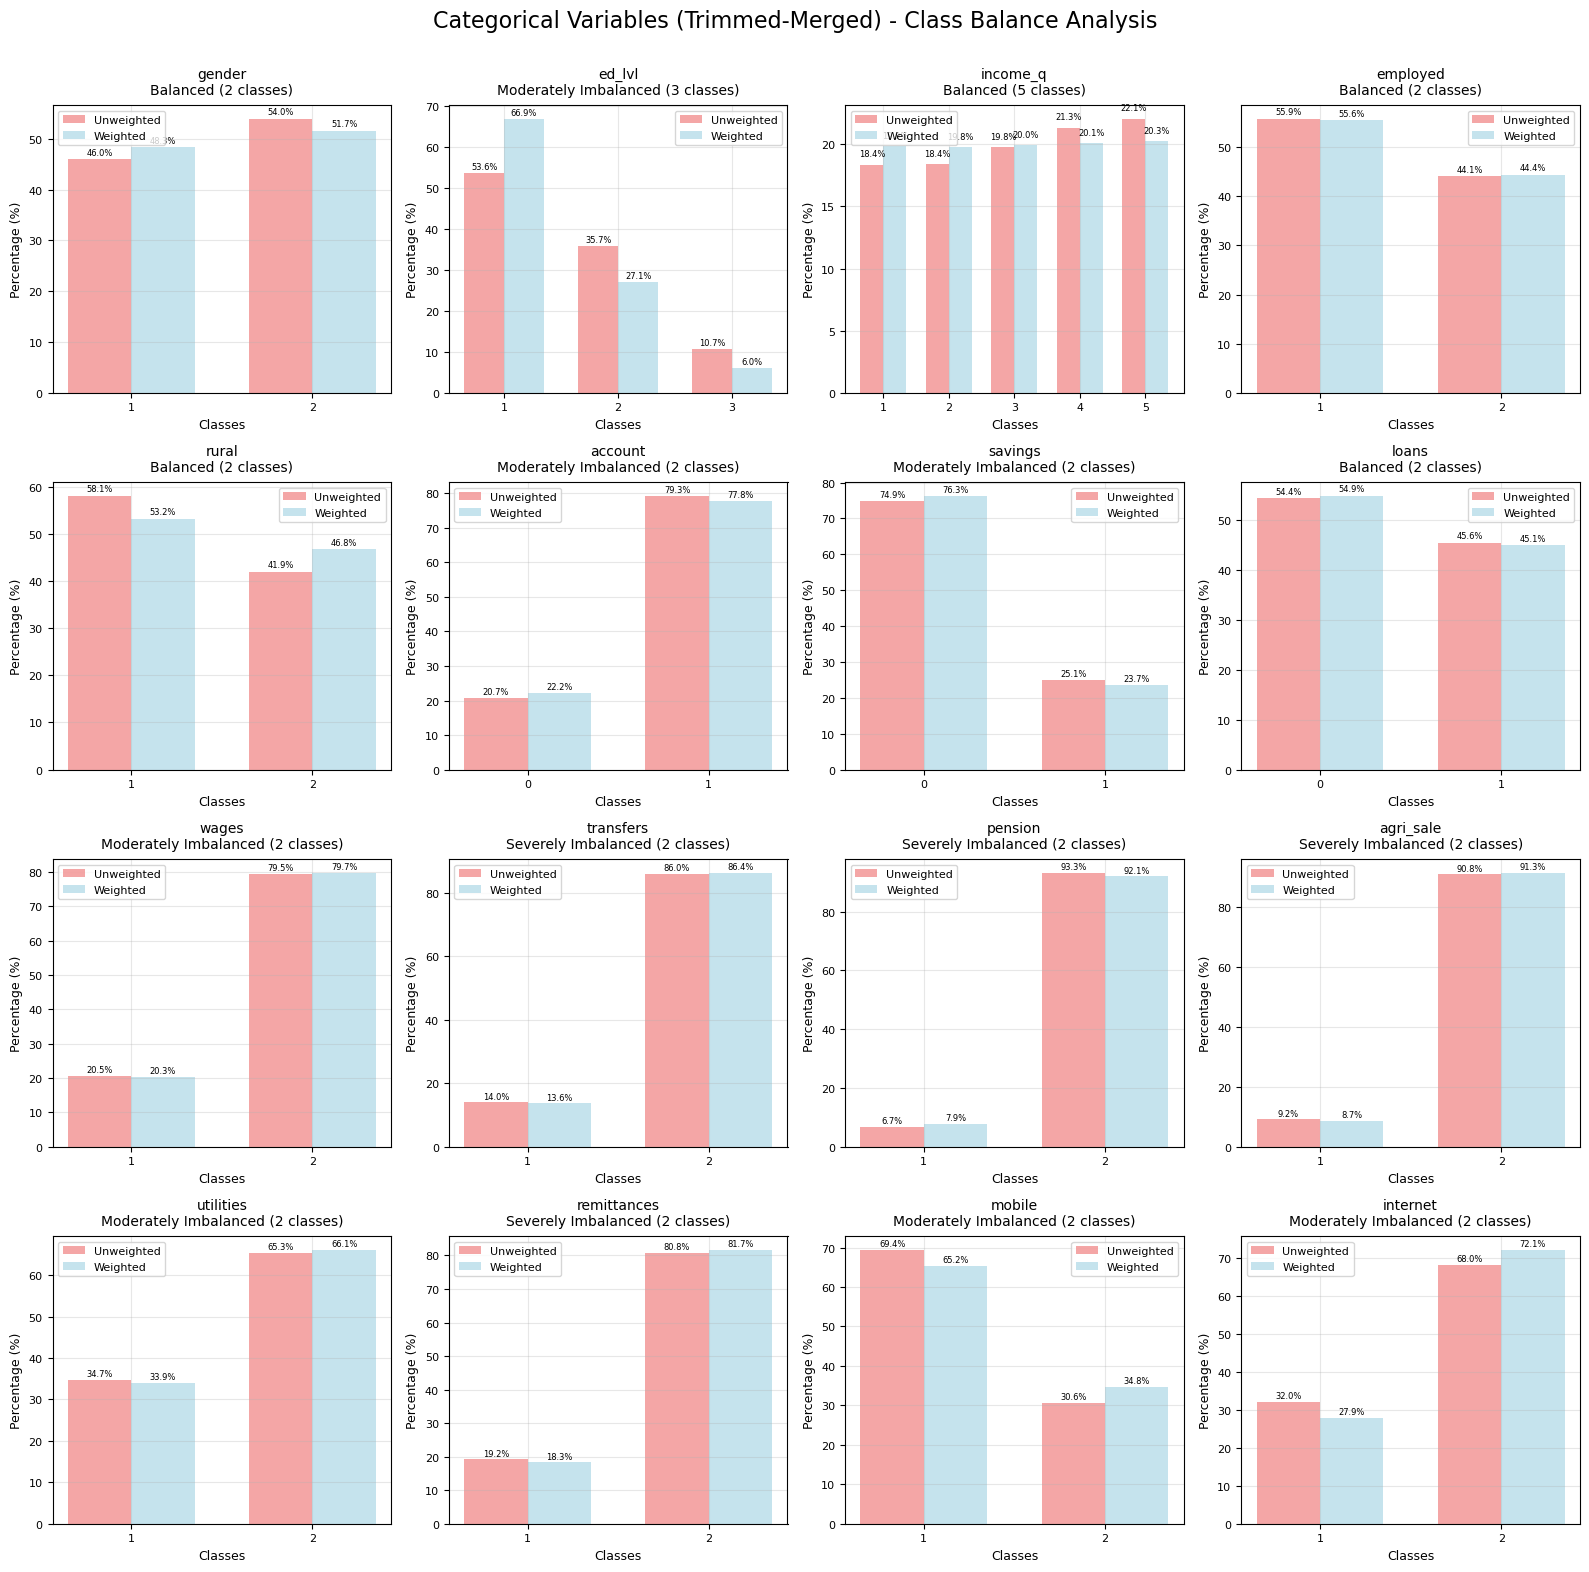

,classes,type,balance_status
gender,2,Binary,Balanced
ed_lvl,3,Multi-class (Ordinal),Moderately Imbalanced
income_q,5,Multi-class (Ordinal),Balanced
employed,2,Binary,Balanced
rural,2,Binary,Balanced
account,2,Binary,Moderately Imbalanced
savings,2,Binary,Moderately Imbalanced
loans,2,Binary,Balanced
wages,2,Binary,Moderately Imbalanced
transfers,2,Binary,Severely Imbalanced


In [5]:
# Trim and Merge
df=preprocessed_data
trimmed_and_merged_df = df.copy()

trim_dict = {
    'mobile': [3, 4], 'internet': [3], 'remittances': [6],
    'utilities': [5], 'agri_sale': [5], 'pension': [5], 'transfers': [5], 'wages': [5]
}

merge_map = {
    'ed_lvl': {3: 3, 4: 3, 5: 3},
    'remittances': {1: 1, 3: 2, 2: 3, 4: 3, 5: 4},  # Merge (2,4)->4 and reorder
}

for col, vals in trim_dict.items():
    trimmed_and_merged_df = trimmed_and_merged_df[~trimmed_and_merged_df[col].isin(vals)]  
for col, mapping in merge_map.items():
    trimmed_and_merged_df[col] = trimmed_and_merged_df[col].replace(mapping)

# Optional Merge for better balance, but low information
financial_features_merge = [
    'wages', 'transfers', 'pension', 'agri_sale', 'utilities', 'remittances'
]

trimmed_and_fmerged_df = trimmed_and_merged_df.copy()
for col in financial_features_merge:
    trimmed_and_fmerged_df[col] = trimmed_and_fmerged_df[col].replace({1: 1, 2: 1, 3: 1, 4: 2})

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(trimmed_and_fmerged_df.shape)))
display(HTML('<span style="font-weight:bold;">Rows Trimmed:</span> ' + f"{(-trimmed_and_fmerged_df.shape[0] + preprocessed_data.shape[0]) / preprocessed_data.shape[0] * 100:.1f}%"))

# Trimmed and Merged Data Plot
df=trimmed_and_fmerged_df
categorical_vars = [col for col in df.columns if col not in ['age', 'wgt']]

# Visualization Format
n_categorical = len(categorical_vars)
n_cols = 4
n_rows = int(np.ceil(n_categorical / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

class_balance_summary = {}

for idx, col in enumerate(categorical_vars):
    if idx >= len(axes):
        break
        
    # Get value counts (unweighted and weighted)
    col_data = df[col].dropna()
    unweighted_counts = col_data.value_counts().sort_index()
    
    # Calculate weighted counts
    col_weights = df.loc[col_data.index, 'wgt']
    weighted_counts = col_data.groupby(col_data).apply(lambda x: col_weights[x.index].sum()).sort_index()
    weighted_props = weighted_counts / weighted_counts.sum() * 100
    unweighted_props = unweighted_counts / unweighted_counts.sum() * 100
    
    # Determine if binary or multi-class
    n_classes = len(unweighted_counts)
    is_binary = n_classes == 2
    
    # Calculate balance metrics
    if is_binary:
        # For binary: calculate minority class percentage
        balance_metric = min(weighted_props.values)
        balance_status = 'Balanced' if balance_metric >= 40 else 'Moderately Imbalanced' if balance_metric >= 20 else 'Severely Imbalanced'
    else:
        # For multi-class: calculate coefficient of variation
        balance_metric = weighted_props.std() / weighted_props.mean() * 100
        balance_status = 'Balanced' if balance_metric <= 50 else 'Moderately Imbalanced' if balance_metric <= 100 else 'Severely Imbalanced'
    
    class_balance_summary[col] = {
        'classes': n_classes,
        'type': 'Multi-class (Ordinal)' if col in ['ed_lvl', 'income_q'] else 'Binary' if is_binary else 'Multi-class',
        'balance_status': balance_status
    }
    
    # Create visualization
    x_pos = range(len(weighted_props))
    width = 0.35
    
    bars1 = axes[idx].bar([p - width/2 for p in x_pos], unweighted_props.values, width,
                         label='Unweighted', alpha=0.7, color='lightcoral')
    bars2 = axes[idx].bar([p + width/2 for p in x_pos], weighted_props.values, width,
                         label='Weighted', alpha=0.7, color='lightblue')
    
    axes[idx].set_title(f'{col}\n{balance_status} ({n_classes} classes)', fontsize=10, pad=8)
    axes[idx].set_xlabel('Classes', fontsize=9)
    axes[idx].set_ylabel('Percentage (%)', fontsize=9)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(weighted_props.index.astype(str), fontsize=8)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='both', labelsize=8)
    
    # Add percentage labels on bars
    for bar1, bar2, val1, val2 in zip(bars1, bars2, unweighted_props.values, weighted_props.values):
        if val1 > 0.1:  # Only label if > 5%
            axes[idx].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
                          f'{val1:.1f}%', ha='center', va='bottom', fontsize=6)
        if val2 > 0.1:
            axes[idx].text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
                          f'{val2:.1f}%', ha='center', va='bottom', fontsize=6)

fig.suptitle('Categorical Variables (Trimmed-Merged) - Class Balance Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Display class balance summary
balance_df = pd.DataFrame.from_dict(class_balance_summary, orient='index')
display(balance_df)

**Insights:**
1. Some multi class have become binary based on merge.
2. Except account, savings, loans and ordinal variables(ed_lvl, income_q) all have to be encoded.
3. OneHot Encoding for multiclass, and reencode (0,1) for binary. 

**Notes:**

Re-encode(0/1) Binary Variables and OneHot Encode Multiclass variables. Exclude ordinal variables(ed_lvl, income_q), [account, savings, loans] (aldready 0/1).

In [6]:
# Encode Variables (OneHot, Reencode(0,1))
df=trimmed_and_merged_df
encoded_data = df.copy()
categorical_vars = [col for col in encoded_data.columns if col not in ['age', 'wgt']]
binary_vars = [col for col in categorical_vars if encoded_data[col].nunique() == 2]
multiclass_vars = [col for col in categorical_vars if encoded_data[col].nunique() > 2]
ordinal_vars = ['income_q', 'ed_lvl']
exclude_vars = ['account', 'savings', 'loans'] + ordinal_vars

# Integer encode binary variables
binary_to_encode = [col for col in binary_vars if col not in exclude_vars]
for col in binary_to_encode:
    encoded_data[col] = encoded_data[col].replace({1: 0, 2: 1})

# One-hot encode multiclass variables (excluding ordinal variables)
multiclass_to_encode = [col for col in multiclass_vars if col not in exclude_vars]
encoded_data = pd.get_dummies(encoded_data, columns=multiclass_to_encode, drop_first=True)

display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(encoded_data.shape)))
display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(encoded_data.head().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))
display(encoded_data.tail().style.set_table_styles([{'selector': 'th.row_heading', 'props': [('min-width', '50px')]}]))


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,mobile,internet,wages_2,wages_3,wages_4,transfers_2,transfers_3,transfers_4,pension_2,pension_3,pension_4,agri_sale_2,agri_sale_3,agri_sale_4,utilities_2,utilities_3,utilities_4,remittances_2,remittances_3,remittances_4
0,0.330000,0,18,3,3,1,0,1,0,0,0,0,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True
1,1.330000,1,41,1,1,1,1,1,0,0,1,1,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True
2,1.460000,1,23,1,2,0,1,1,0,1,0,1,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True
3,0.390000,0,17,2,2,1,0,1,0,0,0,1,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True
4,2.420000,1,27,1,1,0,1,1,1,0,1,1,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,False,True


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,mobile,internet,wages_2,wages_3,wages_4,transfers_2,transfers_3,transfers_4,pension_2,pension_3,pension_4,agri_sale_2,agri_sale_3,agri_sale_4,utilities_2,utilities_3,utilities_4,remittances_2,remittances_3,remittances_4
2995,2.110000,1,65,1,1,0,1,1,0,1,0,1,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True
2996,0.700000,1,32,1,5,0,1,1,0,0,0,0,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,False,False
2997,1.610000,1,18,2,2,0,1,0,0,0,0,1,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True
2998,0.840000,1,36,2,4,0,1,1,0,1,0,0,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True
2999,0.920000,1,48,3,5,0,1,1,1,0,0,0,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,True,False


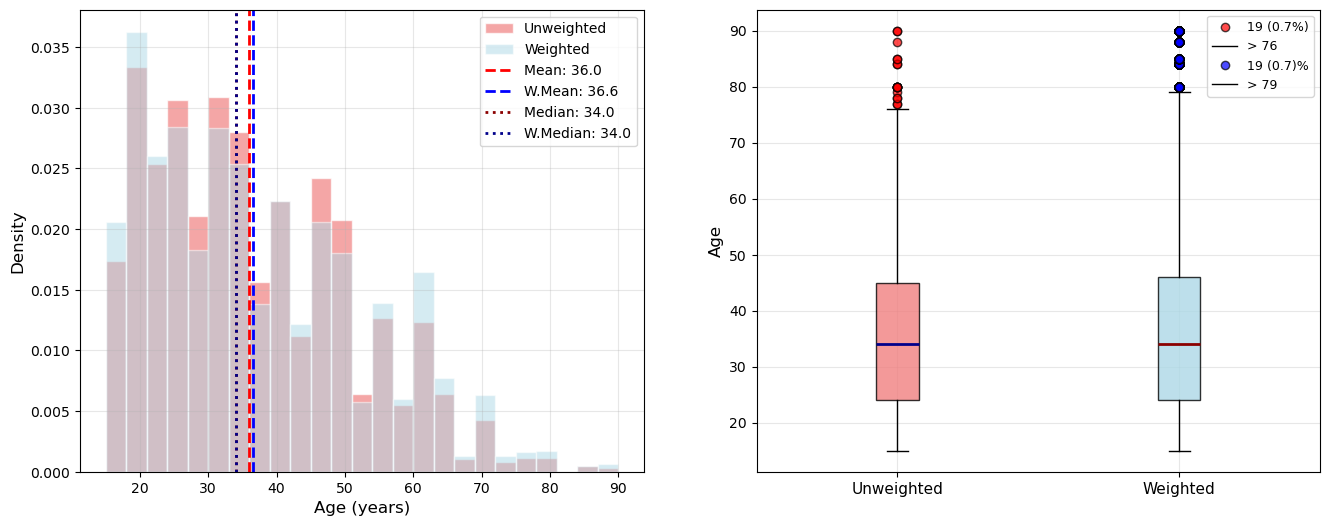

In [7]:
# Continuous Variable Analysis (Age)
df=encoded_data
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram (Distribution)
age_data = df['age']
weights = df['wgt']
wt_age_data = np.repeat(age_data, np.round(weights * 100).astype(int))

ax1.hist(age_data, bins=25, alpha=0.7, color='lightcoral', edgecolor='white', density=True, label='Unweighted')
ax1.hist(age_data, bins=25, weights=weights, density=True, alpha=0.5, color='lightblue', edgecolor='white', label='Weighted')
ax1.axvline(age_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_data.mean():.1f}')
ax1.axvline(np.average(age_data, weights=weights), color='blue', linestyle='--', linewidth=2, label=f'W.Mean: {np.average(age_data, weights=weights):.1f}')
ax1.axvline(age_data.median(), color='darkred', linestyle=':', linewidth=2, label=f'Median: {age_data.median():.1f}')
ax1.axvline(np.median(wt_age_data), color='darkblue', linestyle=':', linewidth=2, label=f'W.Median: {np.median(wt_age_data):.1f}')

ax1.set_xlabel('Age (years)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Box-Plot (Outlier)
Q1, Q3 = age_data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = age_data[(age_data < lower_limit) | (age_data > upper_limit)]
outlier_pct = (len(outliers) / len(age_data)) * 100

# Weighted IQR and outliers (using repeated data)
Q1_wt, Q3_wt = np.percentile(wt_age_data, [25, 75])
IQR_wt = Q3_wt - Q1_wt
lower_limit_wt = Q1_wt - 1.5 * IQR_wt
upper_limit_wt = Q3_wt + 1.5 * IQR_wt

wt_outliers = wt_age_data[(wt_age_data < lower_limit_wt) | (wt_age_data > upper_limit_wt)]
wt_outlier_pct = (len(wt_outliers) / len(wt_age_data)) * 100

bp = ax2.boxplot(age_data, positions=[1], patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.8), medianprops=dict(color='darkblue', linewidth=2), flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.7))
bp_wt = ax2.boxplot(wt_age_data, positions=[2], patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.8), medianprops=dict(color='darkred', linewidth=2), flierprops=dict(marker='o', markerfacecolor='blue', markersize=6, alpha=0.7))
ax2.legend([bp["fliers"][0], bp["whiskers"][1],bp_wt["fliers"][0], bp_wt["whiskers"][1]],[f'{len(outliers)} ({outlier_pct:.1f}%)',f'> {upper_limit:.0f}',f'{len(outliers)} ({wt_outlier_pct:.1f})%',f'> {upper_limit_wt:.0f}'],loc='upper right', fontsize=9)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Unweighted', 'Weighted'], fontsize=11)
ax2.set_ylabel('Age', fontsize=12)
ax2.grid(True, alpha=0.3)

**Insights:**
1. Outliers in sample are of above 76 years of age, and hence is also slightly right skewed. 
2. They can be ommited, as they exceed average lifespan(72) and also India has young economy.
3. The sample data is very close with the weighted sample data representing the population.
4. Use transformation for normalisation if skewness persists even after trimming outliers.

**Notes:**

Trim the outliers. (Age>76)

In [8]:
# Trim Outliers and Check for Skewness
df=encoded_data
trimmed_data = df[df['age'] <= 76].copy()
display(HTML('<span style="font-weight:bold;">Data Shape:</span> ' + str(trimmed_data.shape)))
display(HTML('<span style="font-weight:bold;">Rows Trimmed:</span> ' + f"{-trimmed_data.shape[0] + df.shape[0]} ({(-trimmed_data.shape[0] + df.shape[0]) / df.shape[0] * 100:.1f})%"))

age_data = trimmed_data['age']
weights = trimmed_data['wgt']
wt_age_data = np.repeat(age_data, np.round(weights * 100).astype(int))

display(HTML('<span style="font-weight:bold;">Skewness:</span><br>Unweighted - {:.3f}<br>Weighted - {:.3f}'.format(stats.skew(age_data), stats.skew(wt_age_data))))

**Insights:**
1. Skewness is very mild, square root transformation is best suited because skewness if very mild and there is less infomration loss from transformation.

**Notes:**

Apply Square root transformation to age variable.

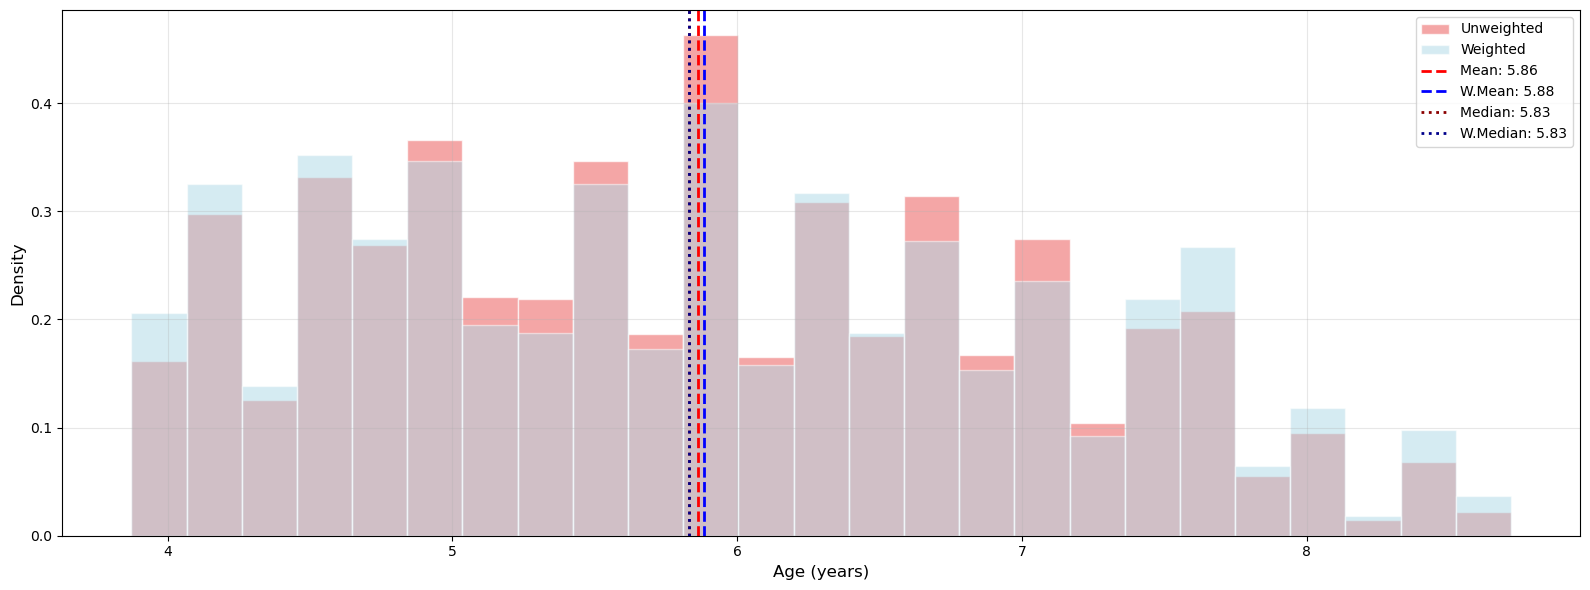

In [9]:
# Apply Square Root Transformation and Check for Skewness
df=trimmed_data
transformed_data=df.copy()
transformed_data['age_sqrt'] = np.sqrt(transformed_data['age'])

age_data = transformed_data['age_sqrt']
weights = transformed_data['wgt']
wt_age_data = np.repeat(age_data, np.round(weights * 100).astype(int))

# 1. Histogram (Distribution)
plt.figure(figsize=(16, 6))
plt.hist(age_data, bins=25, alpha=0.7, color='lightcoral', edgecolor='white', density=True, label='Unweighted')
plt.hist(age_data, bins=25, weights=weights, density=True, alpha=0.5, color='lightblue', edgecolor='white', label='Weighted')
plt.axvline(age_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_data.mean():.2f}')
plt.axvline(float(np.average(age_data, weights=weights)), color='blue', linestyle='--', linewidth=2, label=f'W.Mean: {float(np.average(age_data, weights=weights)):.2f}')
plt.axvline(age_data.median(), color='darkred', linestyle=':', linewidth=2, label=f'Median: {age_data.median():.2f}')
plt.axvline(float(np.median(wt_age_data)), color='darkblue', linestyle=':', linewidth=2, label=f'W.Median: {float(np.median(wt_age_data)):.2f}')

plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(HTML('<span style="font-weight:bold;">Skewness:</span><br>Unweighted - {:.3f}<br>Weighted - {:.3f}'.format(stats.skew(age_data), stats.skew(wt_age_data))))

**Insights:**
1. Distibution is fairly symmetrical now. (skewness-0.25)
2. Scale features - age variable and other ordinal variables(ed_lvl, income_q).
3. Since age is relatively normal now, we can use min max sclaer for easy interpretability and equal scales.

**Notes:**

Apply MinMax scaler for age, ed_lvl and income_q

In [10]:
# Scale Fetures (age, ed_lvl, income_q) [MinMax] 
df = transformed_data
scaled_data = df.copy()
scale_cols = ['age', 'age_sqrt', 'ed_lvl', 'income_q']

scaler = MinMaxScaler()
scaled_data[scale_cols] = scaler.fit_transform(scaled_data[scale_cols])

display(HTML('<span style="font-weight:bold;">Data Preview:</span>'))
display(HTML(
    f"""
    <div style="display: flex; gap: 40px;">
        <div>
            {scaled_data[scale_cols].head().to_html()}
        </div>
        <div>
            {scaled_data[scale_cols].tail().to_html()}
        </div>
    </div>
    """
))
display(scaled_data)

,age,age_sqrt,ed_lvl,income_q
0,0.049180,0.076300,1.0,0.50
1,0.426230,0.522237,0.0,0.00
2,0.131148,0.190482,0.0,0.25
3,0.032787,0.051627,0.5,0.25
4,0.196721,0.273110,0.0,0.00
,age,age_sqrt,ed_lvl,income_q
2995,0.819672,0.864692,0.0,0.00
2996,0.278689,0.368202,0.0,1.00
2997,0.049180,0.076300,0.5,0.25
2998,0.344262,0.439030,0.5,0.75


,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,...,agri_sale_2,agri_sale_3,agri_sale_4,utilities_2,utilities_3,utilities_4,remittances_2,remittances_3,remittances_4,age_sqrt
0,0.33,0,0.049180,1.0,0.50,1,0,1,0,0,...,False,False,True,True,False,False,False,False,True,0.076300
1,1.33,1,0.426230,0.0,0.00,1,1,1,0,0,...,False,False,True,False,False,False,False,False,True,0.522237
2,1.46,1,0.131148,0.0,0.25,0,1,1,0,1,...,False,False,True,True,False,False,False,False,True,0.190482
3,0.39,0,0.032787,0.5,0.25,1,0,1,0,0,...,False,False,True,False,False,True,False,False,True,0.051627
4,2.42,1,0.196721,0.0,0.00,0,1,1,1,0,...,False,False,True,False,True,False,False,False,True,0.273110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2.11,1,0.819672,0.0,0.00,0,1,1,0,1,...,False,False,True,False,False,True,False,False,True,0.864692
2996,0.70,1,0.278689,0.0,1.00,0,1,1,0,0,...,False,False,True,True,False,False,False,False,False,0.368202
2997,1.61,1,0.049180,0.5,0.25,0,1,0,0,0,...,False,False,True,False,False,True,False,False,True,0.076300
2998,0.84,1,0.344262,0.5,0.75,0,1,1,0,1,...,False,False,True,True,False,False,False,False,True,0.439030


**Insights:**
1. Three variables age, ed_lvl and income_q are scaled in range [0,1].
2. The Data is ready for modeling. Only Encoded Data for Decision Tree and Transformed-Scaled Data for SVM and Logistic Regression.

In [11]:
# Export the data to CSV in the Data directory
df=scaled_data
df.drop(columns=['age'], inplace=True)
df.to_csv('../Data/SVM-LR_2.csv', index=False)

**Feature Engineering:**

Categorical Features:

Trimmed: (dont know, refused to answer classes) 
1. (3,4) mobile[<0.1%]
2. (3) internet[1%]
3. (6) remittances[1.3%]
4. (5) utilities[0.5%] agrisale[0.4%] pension[0.1%] transfers[0.7%] wages[1.5%]

Merged: (very rare classes merged, increament<5%)
1. 3(5.7%) ,4(0.1%) ,5(0.2%) ed_lvl -> 3        =>  1 - Primary or less, 2 - Secondary, 3 - Tertiary or more.
2. 2(0.9%), 4(4.6%) remittances ->4 and reorder =>  1 - Via Account, 2 - Via Cash, 3 - Via Other, 4 - Did not send/receive.
3. 1,2,3 wages, transfers, pensiosn, agri_sale, utilities, remmitances -> 1 and reorder => 1 - Sent/Recieved, 2 - Did not send/receive. [All cardinal features becomes binary after merging 3]

Encoded: (Categorical Features)

1. Re-encode Binary - 1/2 => 0/1
2. OneHot(drop first) - MultiClass 

Continuous Feature:

Outlier Trimmed: 
1. Age > 76 (0.3%) - >Life Expectancy

Transformed: 
1. Sqrt transformation - normalisation

Continous and Ordered Categorical Features:

Scaled: 
1. MaxMin Scaler - Age, Ed_lvl, Income_q => [0,1] Range

**Data:**

Decision Tree:
1. DT_1 - Trimmed, Merged(1,2), Encoded(No Dummy Dropped)
2. DT_2 - Trimmed, Merged, Encoded

SVM/Linear Regression
1. SVM-LR_1 - Trimmed, Merged(1,2), Encoded, Outlier Trimmed, Scaled
3. SVM-LR_2 - Trimmed, Merged(1,2), Encoded, Outlier Trimmed, Transformed, Scaled
2. SVM-LR_3 - Trimmed, Merged, Encoded, Outlier Trimmed, Scaled
4. SVM-LR_4 - Trimmed, Merged, Encoded, Outlier Trimmed, Transformed, Scaled